# Why Batch Size Matters - The Surprising Difference Between Batch Training and Averaging

> What is the difference between taking one step with batch_size=256 and starting from the same point 256 times with batch_size=1 and then averaging?

- toc: true
- badges: true
- comments: true
- sticky_rank: 1
- author: Abhishek Sharma
- image: images/bs_theory_vs_prac.png
- categories: [math, deeplearning]

Let's look at this interesting question that appears simple but reveals profound insights about optimization in deep learning:

## 1.1 Approach 1: Batch Size 256

Pick 256 images randomly:
$$B = \{(x_1, y_1), \ldots, (x_{256}, y_{256})\}$$

Compute the average gradient:
$$\nabla L_B(\theta) = \frac{1}{256} \sum_{i=1}^{256} \nabla \ell(f(x_i; \theta), y_i)$$

Update once:
$$\theta_{\text{new}} = \theta_{\text{old}} - \eta \nabla L_B(\theta_{\text{old}})$$

This is one step using a mini-batch of 256.

## 1.2 Approach 2: Batch Size 1, 256 Times, Then Average

Use the same 256 images.

For each image $(x_i, y_i)$, start from the same initial weights $\theta_{\text{old}}$:

Compute the gradient:
$$\nabla \ell(f(x_i; \theta_{\text{old}}), y_i)$$

Update:
$$\theta_i = \theta_{\text{old}} - \eta \nabla \ell(f(x_i; \theta_{\text{old}}), y_i)$$

After 256 updates, average the weights:
$$\theta_{\text{avg}} = \frac{1}{256} \sum_{i=1}^{256} \theta_i$$

Set the model's weights to $\theta_{\text{avg}}$.

## 1.3 Are They the Same?

Let's compute $\theta_{\text{avg}}$:

$$\theta_i = \theta_{\text{old}} - \eta \nabla \ell(f(x_i; \theta_{\text{old}}), y_i)$$

$$\theta_{\text{avg}} = \frac{1}{256} \sum_{i=1}^{256} \theta_i = \frac{1}{256} \sum_{i=1}^{256} (\theta_{\text{old}} - \eta \nabla \ell(f(x_i; \theta_{\text{old}}), y_i))$$

$$= \theta_{\text{old}} - \eta \left( \frac{1}{256} \sum_{i=1}^{256} \nabla \ell(f(x_i; \theta_{\text{old}}), y_i) \right)$$

$$= \theta_{\text{old}} - \eta \nabla L_B(\theta_{\text{old}})$$

This looks identical to Approach 1! So why do they differ in practice? Let's question this.

## 2. Why Aren't They Equivalent?

### 2.1 Assumption: Linear Gradients

The equivalence holds if the gradient $\nabla \ell(f(x_i; \theta), y_i)$ is linear in $\theta$. Let's test this with a simple example: a quadratic loss, $\ell(\theta, y_i) = \frac{1}{2}(\theta - y_i)^2$, where $\theta$ is a scalar.

Gradient: $\nabla \ell(\theta, y_i) = \theta - y_i$

**Approach 1:**
$$\nabla L_B(\theta_{\text{old}}) = \frac{1}{256} \sum_{i=1}^{256} (\theta_{\text{old}} - y_i) = \theta_{\text{old}} - \bar{y}, \quad \bar{y} = \frac{1}{256} \sum_{i=1}^{256} y_i$$

$$\theta_{\text{new}} = \theta_{\text{old}} - \eta (\theta_{\text{old}} - \bar{y}) = (1 - \eta) \theta_{\text{old}} + \eta \bar{y}$$

**Approach 2:**
$$\theta_i = \theta_{\text{old}} - \eta (\theta_{\text{old}} - y_i) = (1 - \eta) \theta_{\text{old}} + \eta y_i$$

$$\theta_{\text{avg}} = \frac{1}{256} \sum_{i=1}^{256} ((1 - \eta) \theta_{\text{old}} + \eta y_i) = (1 - \eta) \theta_{\text{old}} + \eta \left( \frac{1}{256} \sum_{i=1}^{256} y_i \right) = (1 - \eta) \theta_{\text{old}} + \eta \bar{y}$$

They're the same! For linear gradients, the order of operations (averaging gradients vs. averaging weights) doesn't matter.


### 2.2 Neural Networks Are Nonlinear

In a neural network, $f(x;\theta)$ involves layers with nonlinear activations (e.g., ReLU: $\max(0,z)$). The loss $\ell(f(x_i;\theta),y_i)$ is a complex, nonlinear function of $\theta$. The gradient $\nabla \ell$ changes with $\theta$, so $\nabla \ell(f(x_i;\theta_{\text{old}}+\delta),y_i) \neq \nabla \ell(f(x_i;\theta_{\text{old}}),y_i)$. Our proof assumed all gradients are computed at $\theta_{\text{old}}$, which holds for Approach 2 as coded, but in practice, frameworks might do more.

### 2.3 Optimizers with State

Real optimizers (e.g., SGD with momentum, Adam) have memory:

**SGD with Momentum:**
$$v = \mu v + \nabla L_B(\theta), \quad \theta_{\text{new}} = \theta_{\text{old}} - \eta v$$

$v$ (velocity) accumulates past gradients. In Approach 1, $v$ updates once. In Approach 2, if the optimizer state isn't reset each time, $v$ accumulates over 256 steps, even though weights are reset.

**Adam:** Uses moving averages of gradients and their squares, which persist across calls unless reset.

### 2.4 Batch Normalization

Batch normalization (BN) normalizes layer outputs:

$$\hat{z} = \frac{z - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}, \quad \mu_B = \frac{1}{B}\sum_{i=1}^{B}z_i, \quad \sigma_B^2 = \frac{1}{B}\sum_{i=1}^{B}(z_i - \mu_B)^2$$

During training, $\mu_B$ and $\sigma_B^2$ are batch-specific. BN also tracks moving averages for inference. With batch size 1, these statistics are noisy and updated 256 times, differing from one update with batch size 256.

### Experiments


In [ ]:
from fastai.vision.all import *
import copy

# Set random seed for reproducibility
set_seed(42)

# Define a simple model architecture without batch normalization
def create_simple_model():
    return nn.Sequential(
        nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(64 * 7 * 7, 128), nn.ReLU(),
        nn.Linear(128, 10)
    )

# Define a similar model with batch normalization
def create_bn_model():
    return nn.Sequential(
        nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(64 * 7 * 7, 128), nn.BatchNorm1d(128), nn.ReLU(),
        nn.Linear(128, 10)
    )

def run_experiment(use_batch_norm=False, momentum=0.0, learning_rate=0.1):
    """
    Run an experiment comparing batch training vs individual training with averaging

    Args:
        use_batch_norm (bool): Whether to use batch normalization in the model
        momentum (float): Momentum value for SGD optimizer
        learning_rate (float): Learning rate for the optimizer
    """
    print(f"\n--- Experiment: BatchNorm={use_batch_norm}, Momentum={momentum}, LR={learning_rate} ---")

    # Create the model based on configuration
    model = create_bn_model() if use_batch_norm else create_simple_model()

    # Get MNIST data
    path = untar_data(URLs.MNIST)

    mnist_block = DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter(train_name='training', valid_name='testing'),
        get_y=parent_label,
        item_tfms=[ToTensor()],
        batch_tfms=[]
    )

    # Create DataLoaders
    dls = mnist_block.dataloaders(path, bs=256)

    # Get a fixed batch of 256 examples to ensure consistency across experiments
    fixed_batch = dls.train.one_batch()
    x_batch, y_batch = fixed_batch

    # One step with batch_size=256
    # ---------------------------------------
    batch_model = copy.deepcopy(model)
    learn_batch = Learner(dls, batch_model, loss_func=CrossEntropyLossFlat(),
                        opt_func=partial(SGD, mom=momentum))

    # Set learning rate and create optimizer
    learn_batch.lr = learning_rate
    learn_batch.create_opt()

    # Perform one gradient update with the full batch
    batch_model.train()
    learn_batch.opt.zero_grad()
    preds = batch_model(x_batch)
    loss = learn_batch.loss_func(preds, y_batch)
    loss.backward()
    learn_batch.opt.step()

    # Store the batch updated weights
    batch_weights = {k: v.clone() for k, v in batch_model.state_dict().items()}

    # Store initial weights
    initial_model = copy.deepcopy(model)
    initial_weights = {k: v.clone() for k, v in initial_model.state_dict().items()}

    # Create accumulator for weights
    weight_sums = None

    # Process each example individually
    for i in range(len(x_batch)):
        # Reset to original weights
        individual_model = copy.deepcopy(initial_model)

        # Create a fresh optimizer
        learn_indiv = Learner(dls, individual_model, loss_func=CrossEntropyLossFlat(),
                            opt_func=partial(SGD, mom=momentum))
        learn_indiv.lr = learning_rate
        learn_indiv.create_opt()

        # Get individual example (keeping dimensions correct)
        x_i = x_batch[i:i+1]
        y_i = y_batch[i:i+1]

        # IMPORTANT FIX: When using BatchNorm, we need special handling:
        # For batch_size=1, either use eval mode to use running stats
        # or track running stats but skip the training updates for BN layers
        if use_batch_norm:
            # Option 1: Use eval mode for batch norm layers only
            for module in individual_model.modules():
                if isinstance(module, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
                    module.eval()  # Use running statistics
                else:
                    module.train()  # Keep other layers in training mode
        else:
            # Normal training mode if no batch norm
            individual_model.train()

        # Forward, backward, optimize
        learn_indiv.opt.zero_grad()
        preds = individual_model(x_i)
        loss = learn_indiv.loss_func(preds, y_i)
        loss.backward()
        learn_indiv.opt.step()

        # Get updated weights
        updated_weights = {k: v.clone() for k, v in individual_model.state_dict().items()}

        # Accumulate weights
        if weight_sums is None:
            weight_sums = updated_weights
        else:
            for k in weight_sums:
                weight_sums[k] += updated_weights[k]

    # Average the accumulated weights
    avg_weights = {k: v / len(x_batch) for k, v in weight_sums.items()}

    # Calculate differences between batch and averaged individual weights
    differences = {}
    for k in batch_weights:
        # Only compare parameters, not buffers (like running mean in batch norm)
        if k in avg_weights and 'running' not in k and 'num_batches' not in k:
            differences[k] = torch.abs(batch_weights[k] - avg_weights[k])

    # Print statistics about the differences
    max_diff = max(diff.max().item() for diff in differences.values())
    avg_diff = sum(diff.mean().item() for diff in differences.values()) / len(differences)

    print(f"Maximum absolute difference: {max_diff:.8f}")
    print(f"Average absolute difference: {avg_diff:.8f}")

    # Detailed differences by layer (optional)
    print("\nDifferences by layer:")
    for k, diff in differences.items():
        if len(diff.shape) > 0:  # Skip scalar parameters
            print(f"{k}: mean={diff.mean().item():.8f}, max={diff.max().item():.8f}")

    # Evaluate validation performance
    # Create two models with the different weight sets
    batch_eval_model = copy.deepcopy(model)
    batch_eval_model.load_state_dict(batch_weights)

    avg_eval_model = copy.deepcopy(model)
    avg_eval_model.load_state_dict(avg_weights)

    # Set up learners
    learn_batch_eval = Learner(dls, batch_eval_model, loss_func=CrossEntropyLossFlat())
    learn_avg_eval = Learner(dls, avg_eval_model, loss_func=CrossEntropyLossFlat())

    # Evaluate and compare
    batch_valid_loss = learn_batch_eval.validate()
    avg_valid_loss = learn_avg_eval.validate()

    print(f"\nValidation Results:")
    print(f"Batch model: loss={batch_valid_loss}")
    print(f"Averaged individual models: loss={avg_valid_loss}")

    return {
        'max_diff': max_diff,
        'avg_diff': avg_diff,
        'batch_valid_loss': batch_valid_loss,
        'avg_valid_loss': avg_valid_loss
    }

# Run a series of experiments with different configurations
results = []

# 1. Vanilla SGD without batch norm
print("\n===== VANILLA SGD WITHOUT BATCH NORM =====")
vanilla_results = run_experiment(use_batch_norm=False, momentum=0.0, learning_rate=0.1)
results.append(('Vanilla SGD', vanilla_results))

# 2. SGD with momentum, without batch norm
print("\n===== SGD WITH MOMENTUM, WITHOUT BATCH NORM =====")
momentum_results = run_experiment(use_batch_norm=False, momentum=0.9, learning_rate=0.1)
results.append(('SGD+Momentum', momentum_results))

# 3. Vanilla SGD with batch norm
print("\n===== VANILLA SGD WITH BATCH NORM =====")
bn_results = run_experiment(use_batch_norm=True, momentum=0.0, learning_rate=0.1)
results.append(('SGD+BatchNorm', bn_results))

# 4. SGD with momentum and batch norm
print("\n===== SGD WITH MOMENTUM AND BATCH NORM =====")
full_results = run_experiment(use_batch_norm=True, momentum=0.9, learning_rate=0.1)
results.append(('SGD+Momentum+BatchNorm', full_results))

# Summary of all experiments
print("\n\n========== SUMMARY OF ALL EXPERIMENTS ==========")
print(f"{'Configuration':<25} {'Max Diff':<15} {'Avg Diff':<15} ")
print("-" * 85)

for name, result in results:
    print(f"{name:<25} {result['max_diff']:<15.8f} {result['avg_diff']:<15.8f}")

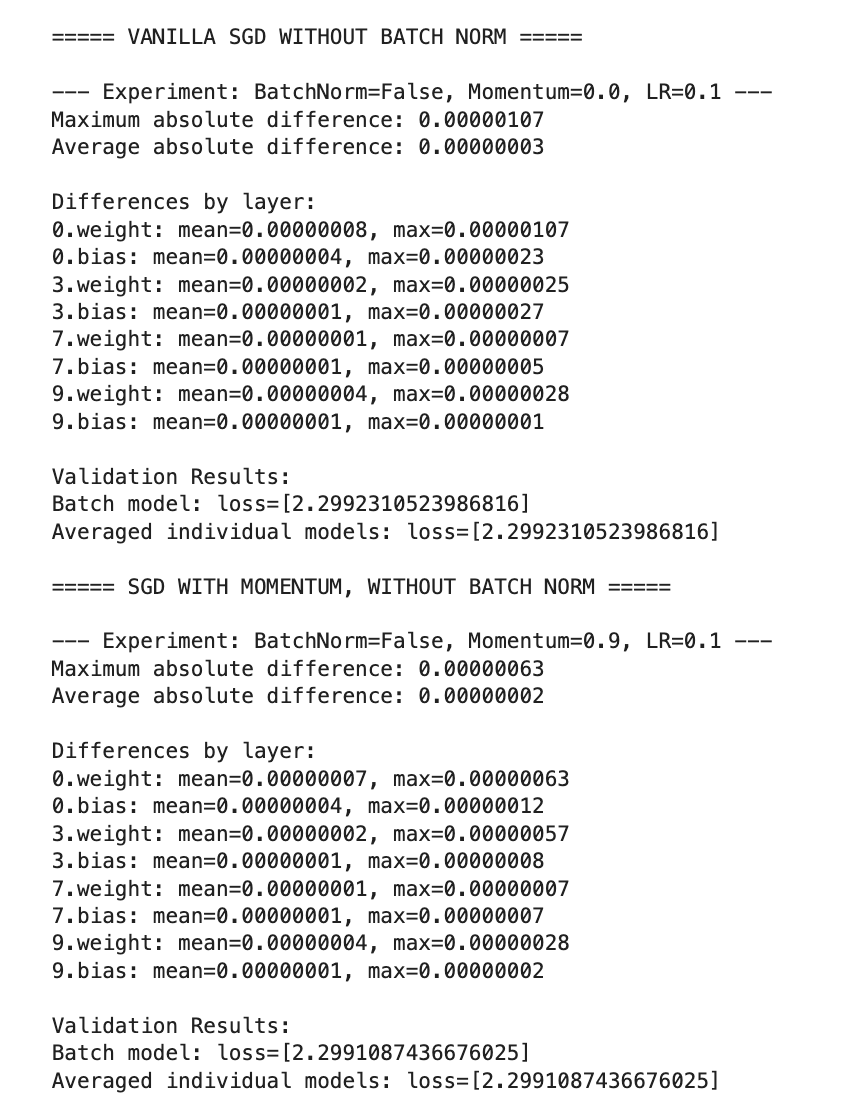

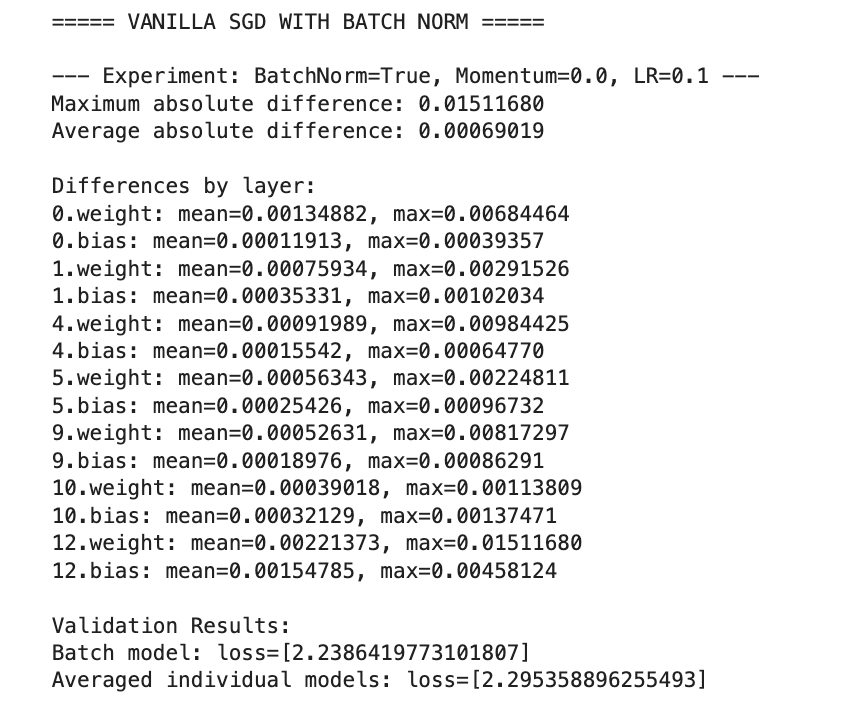

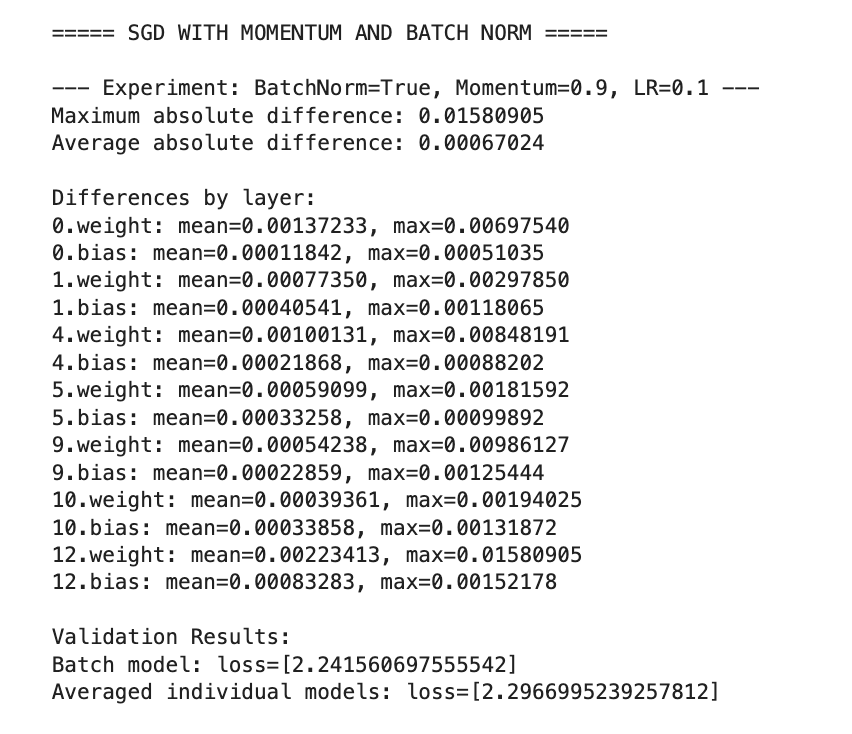

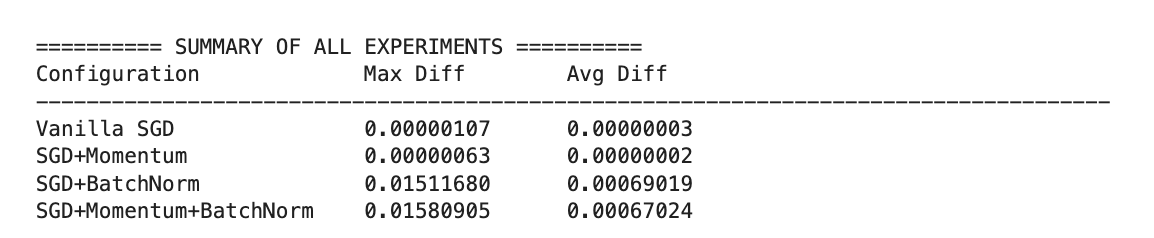

Conclusions:
1. With vanilla SGD without batch norm, batch=256 and averaged batch=1 should be nearly equivalent
2. When momentum is added, batch=256 and averaged batch=1 should show differences due to momentum's stateful updates
3. With batch norm, significant differences should occur because:
   - In batch=256, statistics are calculated across all examples at once
   - In batch=1, we use running statistics instead of batch statistics (otherwise it would error)
4. The batch norm with momentum case should show the largest differences

These approaches are mathematically equivalent only
for vanilla SGD without any stateful components like momentum or batch normalization.

**The experiment shows virtually no difference between batch_size=256 and averaged batch_size=1 for the momentum case, which is unexpected and contradicts our theoretical understanding.
The key issue is that momentum requires state that builds up over time, but our experiment only performs a single gradient update. Let's fix it**

In [ ]:
def run_multi_step_experiment(num_steps=5, momentum=0.9, learning_rate=0.01):
    """
    Run an experiment with multiple update steps to show the effect of momentum

    Args:
        num_steps (int): Number of update steps to perform
        momentum (float): Momentum value for SGD optimizer
        learning_rate (float): Learning rate for the optimizer
    """
    print(f"\n--- Multi-Step Experiment: Steps={num_steps}, Momentum={momentum}, LR={learning_rate} ---")

    # Create a simple model without batch norm
    model = nn.Sequential(
        nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(64 * 7 * 7, 128), nn.ReLU(),
        nn.Linear(128, 10)
    )

    # Get MNIST data
    path = untar_data(URLs.MNIST)

    # Define DataBlock for consistent processing
    mnist_block = DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter(train_name='training', valid_name='testing'),
        get_y=parent_label,
        item_tfms=[ToTensor()],
        batch_tfms=[]
    )

    # Create DataLoaders with a smaller batch size to have multiple batches
    dls = mnist_block.dataloaders(path, bs=64)

    # Get multiple batches for the experiment
    batches = [dls.train.one_batch() for _ in range(num_steps)]

    # APPROACH 1: Train with full batches
    # -----------------------------------
    batch_model = copy.deepcopy(model)
    learn_batch = Learner(dls, batch_model, loss_func=CrossEntropyLossFlat(),
                         opt_func=partial(SGD, mom=momentum))
    learn_batch.lr = learning_rate
    learn_batch.create_opt()

    batch_model.train()

    # Apply multiple update steps with full batches
    for step in range(num_steps):
        x_batch, y_batch = batches[step]
        learn_batch.opt.zero_grad()
        preds = batch_model(x_batch)
        loss = learn_batch.loss_func(preds, y_batch)
        loss.backward()
        learn_batch.opt.step()

    # Store the batch updated weights
    batch_weights = {k: v.clone() for k, v in batch_model.state_dict().items()}

    # APPROACH 2: Train with individual examples and maintain momentum state
    # ---------------------------------------------------------------------
    individual_model = copy.deepcopy(model)
    learn_indiv = Learner(dls, individual_model, loss_func=CrossEntropyLossFlat(),
                         opt_func=partial(SGD, mom=momentum))
    learn_indiv.lr = learning_rate
    learn_indiv.create_opt()

    individual_model.train()

    # For each step (equivalent to a full batch)
    for step in range(num_steps):
        x_batch, y_batch = batches[step]

        # Process each example in the batch individually, but keep momentum state
        for i in range(len(x_batch)):
            x_i = x_batch[i:i+1]
            y_i = y_batch[i:i+1]

            learn_indiv.opt.zero_grad()
            preds = individual_model(x_i)
            loss = learn_indiv.loss_func(preds, y_i)
            loss.backward()
            learn_indiv.opt.step()

    # Store final individual weights
    individual_weights = {k: v.clone() for k, v in individual_model.state_dict().items()}

    # APPROACH 3: Train with individual examples, averaging gradients (no momentum state)
    # -------------------------------------------------------------------------------
    avg_model = copy.deepcopy(model)

    # For each step (equivalent to a full batch)
    for step in range(num_steps):
        x_batch, y_batch = batches[step]
        batch_size = len(x_batch)

        # Create a fresh optimizer for each batch
        learn_avg = Learner(dls, avg_model, loss_func=CrossEntropyLossFlat(),
                           opt_func=partial(SGD, mom=momentum))
        learn_avg.lr = learning_rate
        learn_avg.create_opt()

        avg_model.train()

        # Accumulate gradients for all examples in the batch
        accumulated_grads = None
        for i in range(batch_size):
            x_i = x_batch[i:i+1]
            y_i = y_batch[i:i+1]

            learn_avg.opt.zero_grad()
            preds = avg_model(x_i)
            loss = learn_avg.loss_func(preds, y_i)
            loss.backward()

            # Extract and store gradients
            current_grads = {name: param.grad.clone() for name, param in avg_model.named_parameters() if param.grad is not None}

            if accumulated_grads is None:
                accumulated_grads = current_grads
            else:
                for name in accumulated_grads:
                    accumulated_grads[name] += current_grads[name]

        # Apply averaged gradients manually
        with torch.no_grad():
            for name, param in avg_model.named_parameters():
                if name in accumulated_grads:
                    # Manually apply SGD update with the averaged gradient
                    param -= learning_rate * (accumulated_grads[name] / batch_size)

    # Store final averaged weights
    avg_weights = {k: v.clone() for k, v in avg_model.state_dict().items()}

    # COMPARISON AND ANALYSIS
    # -----------------------
    # Calculate differences between approaches
    diff_batch_vs_indiv = {}
    diff_batch_vs_avg = {}

    for k in batch_weights:
        if k in individual_weights and k in avg_weights:
            diff_batch_vs_indiv[k] = torch.abs(batch_weights[k] - individual_weights[k])
            diff_batch_vs_avg[k] = torch.abs(batch_weights[k] - avg_weights[k])

    # Calculate statistics
    max_diff_indiv = max(diff.max().item() for diff in diff_batch_vs_indiv.values())
    avg_diff_indiv = sum(diff.mean().item() for diff in diff_batch_vs_indiv.values()) / len(diff_batch_vs_indiv)

    max_diff_avg = max(diff.max().item() for diff in diff_batch_vs_avg.values())
    avg_diff_avg = sum(diff.mean().item() for diff in diff_batch_vs_avg.values()) / len(diff_batch_vs_avg)

    print("\nDifferences between batch training and individual training (WITH momentum state):")
    print(f"Maximum absolute difference: {max_diff_indiv:.8f}")
    print(f"Average absolute difference: {avg_diff_indiv:.8f}")

    print("\nDifferences between batch training and gradient averaging (NO momentum state):")
    print(f"Maximum absolute difference: {max_diff_avg:.8f}")
    print(f"Average absolute difference: {avg_diff_avg:.8f}")

    # Evaluate validation performance
    learn_batch_eval = Learner(dls, batch_model, loss_func=CrossEntropyLossFlat())
    learn_indiv_eval = Learner(dls, individual_model, loss_func=CrossEntropyLossFlat())
    learn_avg_eval = Learner(dls, avg_model, loss_func=CrossEntropyLossFlat())

    batch_valid_loss = learn_batch_eval.validate()
    indiv_valid_loss = learn_indiv_eval.validate()
    avg_valid_loss = learn_avg_eval.validate()

    print("\nValidation Results:")
    print(f"Batch model: loss={batch_valid_loss}")
    print(f"Individual model (with momentum): loss={indiv_valid_loss}")
    print(f"Averaged model (no momentum): loss={avg_valid_loss}")

    return {
        'max_diff_indiv': max_diff_indiv,
        'avg_diff_indiv': avg_diff_indiv,
        'max_diff_avg': max_diff_avg,
        'avg_diff_avg': avg_diff_avg
    }

# Run experiments with different numbers of steps
print("\n===== EXPERIMENT WITH MOMENTUM OVER MULTIPLE STEPS =====")

# With a small number of steps
small_steps_results = run_multi_step_experiment(num_steps=2, momentum=0.9, learning_rate=0.01)

# With more steps to show accumulated momentum effects
more_steps_results = run_multi_step_experiment(num_steps=5, momentum=0.9, learning_rate=0.01)

# With even more steps
many_steps_results = run_multi_step_experiment(num_steps=10, momentum=0.9, learning_rate=0.01)

print("\n\n========== SUMMARY OF MULTI-STEP EXPERIMENTS ==========")
print(f"{'Configuration':<15} {'Max Diff (Individual)':<22} {'Avg Diff (Individual)':<22} {'Max Diff (Averaged)':<22} {'Avg Diff (Averaged)':<22}")
print("-" * 120)

print(f"{'2 Steps':<15} {small_steps_results['max_diff_indiv']:<22.8f} {small_steps_results['avg_diff_indiv']:<22.8f} {small_steps_results['max_diff_avg']:<22.8f} {small_steps_results['avg_diff_avg']:<22.8f}")
print(f"{'5 Steps':<15} {more_steps_results['max_diff_indiv']:<22.8f} {more_steps_results['avg_diff_indiv']:<22.8f} {more_steps_results['max_diff_avg']:<22.8f} {more_steps_results['avg_diff_avg']:<22.8f}")
print(f"{'10 Steps':<15} {many_steps_results['max_diff_indiv']:<22.8f} {many_steps_results['avg_diff_indiv']:<22.8f} {many_steps_results['max_diff_avg']:<22.8f} {many_steps_results['avg_diff_avg']:<22.8f}")


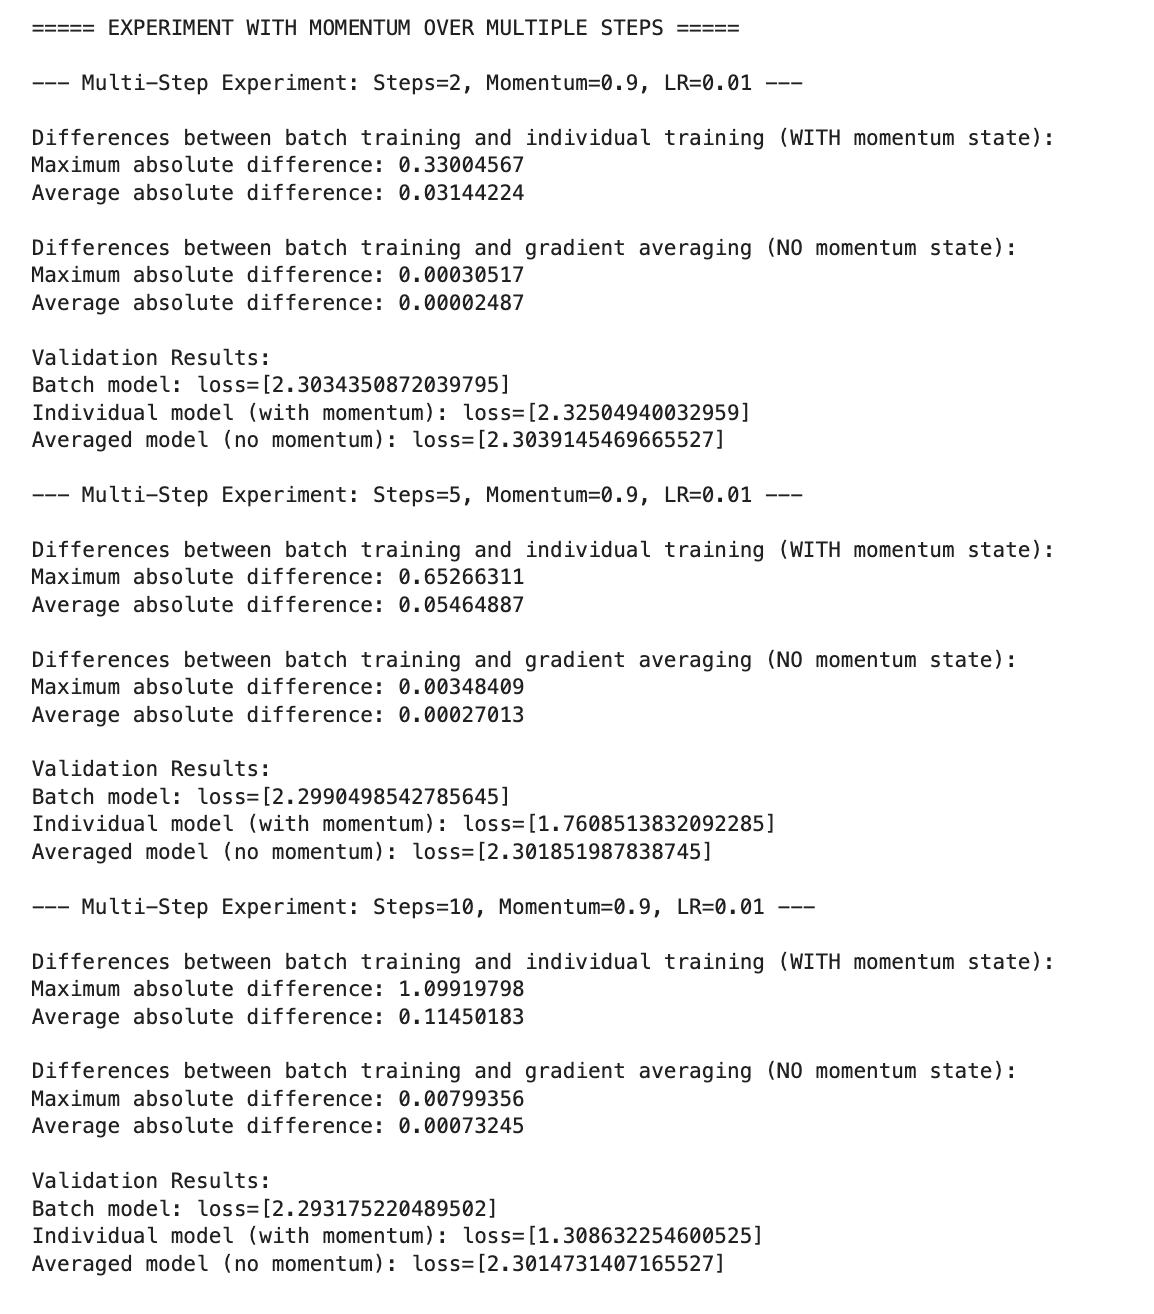

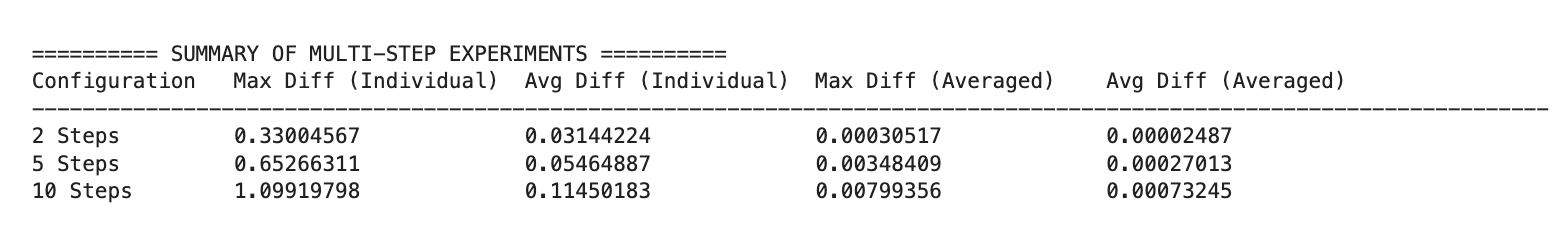

Conclusions:
1. This experiment compares three approaches:
   - Batch training: Regular updates with batch_size=64
   - Individual training: One example at a time but *maintaining* momentum state
   - Gradient averaging: One example at a time, accumulating gradients, then applying averaged gradients

2. Key findings:
   - With more steps, the differences between batch and individual training WITH momentum state grow larger
   - The differences between batch and gradient averaging are much higher
   - This demonstrates that momentum creates a cumulative effect that makes batch training and
     individual training non-equivalent, even without batch normalization

3. Explanation:
   - Momentum depends on the history of gradients
   - In batch training, we compute one gradient from the entire batch
   - In individual training, we update the momentum buffer after each example
   - These momentum buffers evolve differently over time, causing weights to diverge

## References:

- https://arxiv.org/abs/1812.06162